In [185]:
import requests
import json
import time
import pickle
from gensim.utils import simple_preprocess
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import TaggedDocument
from lbl2vec import Lbl2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
from requests.auth import HTTPBasicAuth
from urllib.parse import quote_plus
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

KEY_311 = os.environ.get('311_API_KEY')
AUTH_311 = HTTPBasicAuth('key', KEY_311)
API_URL_311 = 'https://boston2-production.spotmobile.net/open311/v2/services.json'
ILLEGAL_PARKING_SERVICE_CODE = quote_plus("Transportation - Traffic Division:Enforcement & Abandoned Vehicles:Parking Enforcement")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\0mmaa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


# Outline:
0. Data Collection
1. Data Preparation
3. Data Preprocessing
4. Model Training
5. Model Evaluation
6. Model Prediction

# 0. Data Collection

## Methods to gather service request JSON objects from the Boston Open311 API Endpoint

These methods will request all available service requests (limited to last 90 days) and write the resulting JSON array of service requests to the given filename.

In [2]:
def execute_single_query(page_num:int):
    ''' 
    Sends an HTTP GET request to the Boston 311 API for Illegal Parking.
    Requests 100 (maximum allowed) service requests for a given page.
    
    Returns: HTTP Response Object
    '''
    query_url = f'https://boston2-production.spotmobile.net/open311/v2/requests.json?service_code={ILLEGAL_PARKING_SERVICE_CODE}&per_page=100&page={page_num}'

    return requests.get(url=query_url, auth=AUTH_311)

def retreive_all_service_requests(filename:str):
    ''' 
    Continually sends HTTP Requests to the Boston 311 API for Illegal Parking Service Requests.
    Concatenates responses into a single JSON Array containing Service Request JSON Objects.
    Updates are sent to the console throughout the process.
    Returns: writes the JSON Array to the given filename, once all service requests are received.
    '''

    # Executes first query
    page = 1
    current_response = execute_single_query(page)

    # Ensure HTTP Error is captured
    if current_response.status_code != 200:
        print(f'First Query failed. Error code: {current_response.status_code}')
        return
    page+=1
    
    # Creates JSON Array Object on response
    all_service_requests_json = current_response.json()

    # Continually execute queries for the next page until there are no more (Error Code != 200, 429)
    while True:
        current_response = execute_single_query(page)
        status_code = current_response.status_code

        # Successful response has service request JSON Objects concatenated to end of overall JSON Array
        if status_code == 200:
            print(f'Query Received: {page}')
            for service_request_obj in current_response.json():
                all_service_requests_json.append(service_request_obj)
            page += 1
        
        # Error code 429 indicates rate limiting (10 GET Requests per min)
        elif status_code == 429:
            print(f'Rate Limited: Waiting 1 minute. \n Current Page {page}')
            # Wait 60 seconds to resume query
            time.sleep(60)
            print('Resuming Query...')
        
        # Any other error code, break loop.
        else: 
            print(f'Error recieved: {status_code}')
            break

    print(f'Finished querying. Total pages queried: {page}\n Printing...')

    # Write received service requests to specificed filename
    all_service_requests_file = open(filename, 'w')
    all_service_requests_file.write(json.dumps(all_service_requests_json))
    all_service_requests_file.close()

In [3]:
SERVICE_REQ_JSON_FILE_NAME = 'service_requests_last_90_days.json'
retreive_all_service_requests(SERVICE_REQ_JSON_FILE_NAME)

Query Received: 2
Query Received: 3
Query Received: 4
Query Received: 5
Query Received: 6
Query Received: 7
Query Received: 8
Query Received: 9
Query Received: 10
Rate Limited: Waiting 1 minute. 
 Current Page 11
Resuming Query...
Query Received: 11
Query Received: 12
Query Received: 13
Query Received: 14
Query Received: 15
Query Received: 16
Query Received: 17
Query Received: 18
Query Received: 19
Query Received: 20
Rate Limited: Waiting 1 minute. 
 Current Page 21
Resuming Query...
Query Received: 21
Query Received: 22
Query Received: 23
Query Received: 24
Query Received: 25
Query Received: 26
Query Received: 27
Query Received: 28
Query Received: 29
Query Received: 30
Rate Limited: Waiting 1 minute. 
 Current Page 31
Resuming Query...
Query Received: 31
Query Received: 32
Query Received: 33
Query Received: 34
Query Received: 35
Query Received: 36
Query Received: 37
Query Received: 38
Query Received: 39
Query Received: 40
Query Received: 41
Query Received: 42
Rate Limited: Waiting 1 m

# 1. Data Preparation

The following method prepares the JSON array of service request JSON objects, extracting the free-form text description and service request ID from each object. These description and ID pairs are stored in a dictionary which is then pickled for later use.

In [4]:
def extract_request_id_with_description(filename:str) -> dict:
    ''' 
    For a given file containing a JSON Array of Service Request JSON Objects, extract the service number and the description
    (if it exists) into a dictionary for further preprocessing.

    Returns: Dict (Service Request ID -> Service Request Description)
    '''
    request_id_descr_dict = {}
    service_requests_json = json.loads(open(filename, 'r').read())

    for service_request in service_requests_json:
        # Ensure the description exists for this service request
        description = service_request.get('description', False)
        if not description: continue   

        # Add to dictionary using service request ID as key and service request description as value.
        request_id_descr_dict[service_request['service_request_id']] = service_request['description']

    return request_id_descr_dict

In [5]:
PICKLED_SERVICE_REQ_DESC = 'service_req_last_90_days.pkl'

In [6]:
# Create dictionary and store it as a python pickle file for later use.    
service_requests_with_description_file = open(PICKLED_SERVICE_REQ_DESC, 'wb')

dict = extract_request_id_with_description(SERVICE_REQ_JSON_FILE_NAME)

pickle.dump(dict, service_requests_with_description_file)

service_requests_with_description_file.close()

# 2. Data Preprocessing

## Identifying labels and keywords

Labels:

    1.  Bike Lane Obstruction: bike, cycle, path,  
    2.  Bus Lane Obstruction: bus, stop, 
    3.  Non-resident Parking: resident, state
    4.  Blocked Fire Hydrant: fire, hydrant
    5.  Blocked Sidewalk: sidewalk, side
    6.  Blocked Driveway: driveway, drive, way, private
    7.  Blocked Crosswalk: crosswalk, cross
    8.  Blocked Handicap spot: handicap, placard,
    9.  Double Parking: double, triple
    10. No stopping zone: stopping, zone
    11. visitor spot: visitor, hour

In [331]:
category_keywords_dict = {
    'bike lane' :           ['bike'],
    'bus lane' :            ['bus'],
    'resident parking' :    ['resident', 'state'],
    'fire hydrant' :        ['fire', 'hydrant'],
    'sidewalk' :            ['sidewalk'],
    'driveway' :            ['driveway'],
    'crosswalk' :           ['crosswalk'],
    'handicap' :            ['handicap', 'placard'],
    'double parking' :      ['double'],
    'no stopping' :         ['stopping',],
    'visitor parking' :     ['visitor',]
} 

NUM_LABELS = len(category_keywords_dict.keys())

category_keywords = pd.DataFrame(data=category_keywords_dict.items(), columns=['category', 'keywords'])
category_keywords

,category,keywords
0,bike lane,[bike]
1,bus lane,[bus]
2,resident parking,"[resident, state]"
3,fire hydrant,"[fire, hydrant]"
4,sidewalk,[sidewalk]
5,driveway,[driveway]
6,crosswalk,[crosswalk]
7,handicap,"[handicap, placard]"
8,double parking,[double]
9,no stopping,[stopping]


## Identifying high frequency words

Because all of the documents are Illegal Parking service requests, they will share many similar words. The word, document, and label embeddings will come from the context of these words. If the context is very similar, it will be hard for the model to perform clustering and classification. In order to exagerate the differences between the documents, the top 10 most frequent words (based on all documents) can be removed from the documents. However, it must be ensured that none of the words which are removed are specific to a single class (if one class is very dominant and has a very specific word that is used frequently, it should not be removed.)

Through a simple count of the most frequent words, a custom stop-list can be defined for this context. As can be seen below, many of the most frequent words are not specific to a single class, and removing them can help to distinguish one class from another.

In [332]:
all_words_in_desc = [word for desc in dict.values() for word in simple_preprocess(desc)]

TEN_PCT_THRESHOLD = len(dict.values()) * 0.10

all_words_counts = np.unique(all_words_in_desc, return_counts=True)
all_words_counts_dict = {
    'words': all_words_counts[0],
    'counts': all_words_counts[1]
}
all_words_counts_df = pd.DataFrame(all_words_counts_dict)
all_words_counts_df = all_words_counts_df[all_words_counts_df.counts > TEN_PCT_THRESHOLD]
all_words_counts_df.sort_values('counts', inplace=True, ascending=False)
all_words_counts_df

,words,counts
3675,parked,6513
4984,the,5884
2510,in,4826
3682,parking,4206
753,car,3921
2613,is,3299
193,and,3229
3550,of,3181
5335,vehicle,2899
3575,on,2542


Define a custom stop word list using NLTK stop word list as well as the most frequent words from this corpus. To ensure no keywords will be removed, we create a protected stop list which makes sure no keywords are included.

In [333]:
custom_stop_list = list(all_words_counts_df['words']) + list(stopwords.words('english'))
all_keywords = [word for keywords in category_keywords['keywords'] for word in keywords]
protected_stop_word_list = [word for word in custom_stop_list if word not in all_keywords]

## Tokenization and Frequent Word Removal

The simple_preprocess method from gensim removes accents and special characters, then downcasing and tokenizing the document, removing any word with length less than 2 or greater than 15.

In [334]:
# Remove special characters and downcase, then tokenize
def tokenize(doc):
    tokenized_doc = simple_preprocess(doc, deacc=True, min_len=2, max_len=15)
    return [word for word in tokenized_doc if word not in protected_stop_word_list]

## Training, Validation, Testing Data Split

After retreiving the pickled service request ID to description dictionary, create a DataFrame to store the data.

In [335]:
# Load pickled service descriptions
with open(PICKLED_SERVICE_REQ_DESC, 'rb') as file:
    service_id_to_descriptions:dict = pickle.load(file)

service_drescriptions_df = pd.DataFrame(data=service_id_to_descriptions.items(), columns=['ID', 'Description'])
service_drescriptions_df.head()

,ID,Description
0,101005414175,Beat up Toyota van with plate number 447FT6 il...
1,101005414174,Out of state parking in resident parking and b...
2,101005414165,Illegal parking again. This only happens when ...
3,101005414155,A white Honda civic is blocking my driveway P...
4,101005414148,Double parked car


Split the data between training, validation, and testing using sklearn's train_test_split() method. The data is split 70/15/15 between training, validation, and testing, respectively.

In [336]:
# Train=.70, Validate=.15, Test=.15
# Split all data between train, (test AND validate)
desc_train, desc_testval = train_test_split(service_drescriptions_df, test_size=.3)

# Split (test AND validate) between test, validate
# .3 * .5 = 0.15
desc_val, desc_test = train_test_split(desc_testval, test_size=0.5)

After splitting the data, mark its data type and re-concatenate into a DataFrame.

In [337]:
desc_train['data_type'] = 'train'
desc_test['data_type'] = 'test'
desc_val['data_type'] = 'validate'

all_descriptions = pd.concat([desc_train, desc_test, desc_val]).reset_index(drop=True)
all_descriptions.head()

,ID,Description,data_type
0,101005335278,The constituent states that its a no parking s...,train
1,101005344991,parked on side walk and blocking traffic | How...,train
2,101005405071,Out of state parked in resident only,train
3,101005412063,"Hazard seen at Mon, Apr 15, 2024, 4:09 PM EDT ...",train
4,101005338990,Illegal parking in a school bus zone. 174 ipsw...,train


## Document Tagging

The Lbl2Vec model takes in tagged documents, where each document has an integer tag which is used to keep track of the document, its vector, and labels. In order to use these labels after the model is trained, a function is created which maps the service request ID to a document tag integer. The service request ID cannot be used as a document tag because when the Lbl2Vec model sees a tag like 101005244674, it assumes there are documents with tags from [0, 101005244674], resulting in too much memory being allocated. Currently, the function simply uses the index of a list of service request IDs as the document tags, which is not a very sustainable hash function at scale, but it does ensure the document tags are as small as possible, avoiding the memory allocation error.

In [338]:
service_id_list = []
def service_id_to_tag(service_id:int) -> int:
    ''' 
    Simple hash function for converting Service Request IDs to document tags.
    Simply uses the index in a list of Service Request IDs as the document tag.
    This is not the most efficient implementation, but it minimizes the size of the document tag integers.
    '''
    if service_id in service_id_list:
        return service_id_list.index(service_id)
    service_id_list.append(service_id)
    return len(service_id_list) - 1

For each description in the DataFrame, apply tokenization and tag the document.

In [339]:
all_descriptions['tagged_desc'] = all_descriptions.apply(lambda row: TaggedDocument(tokenize(row['Description']), [service_id_to_tag(int(row['ID']))]), axis=1)
all_descriptions.head()

,ID,Description,data_type,tagged_desc
0,101005335278,The constituent states that its a no parking s...,train,"([constituent, states, spot, overnight, moved,..."
1,101005344991,parked on side walk and blocking traffic | How...,train,"([side, walk, traffic, toyota, white, registra..."
2,101005405071,Out of state parked in resident only,train,"([state, resident], [2])"
3,101005412063,"Hazard seen at Mon, Apr 15, 2024, 4:09 PM EDT ...",train,"([hazard, seen, mon, apr, pm, edt, reported, l..."
4,101005338990,Illegal parking in a school bus zone. 174 ipsw...,train,"([illegal, school, bus, zone, ipswich, st], [4])"


# 3. Model Training

## Model Definition

Through hyperparameter tuning, the optimal hyperparameters for the Lbl2Vec model are as follows:
   
    min_count=10
    window=10
    similarity_threshold=0.3

In [340]:
model = Lbl2Vec(
    keywords_list=list(category_keywords['keywords']),
    tagged_documents=all_descriptions['tagged_desc'][all_descriptions['data_type'] == 'train'],
    label_names=list(category_keywords['category']),
    min_count=10, 
    similarity_threshold=0.3,
    clean_outliers=True
    )

## Fitting the model

In [341]:
model.fit()

2024-04-17 20:23:31,103 - Lbl2Vec - INFO - Train document and word embeddings
2024-04-17 20:23:31,103 - Lbl2Vec - INFO - Train document and word embeddings
2024-04-17 20:23:31,103 - Lbl2Vec - INFO - Train document and word embeddings
2024-04-17 20:23:31,103 - Lbl2Vec - INFO - Train document and word embeddings
2024-04-17 20:23:31,103 - Lbl2Vec - INFO - Train document and word embeddings
2024-04-17 20:23:31,103 - Lbl2Vec - INFO - Train document and word embeddings
2024-04-17 20:23:31,103 - Lbl2Vec - INFO - Train document and word embeddings
2024-04-17 20:23:31,103 - Lbl2Vec - INFO - Train document and word embeddings
2024-04-17 20:23:31,103 - Lbl2Vec - INFO - Train document and word embeddings
2024-04-17 20:23:31,103 - Lbl2Vec - INFO - Train document and word embeddings
2024-04-17 20:23:31,103 - Lbl2Vec - INFO - Train document and word embeddings
2024-04-17 20:23:31,103 - Lbl2Vec - INFO - Train document and word embeddings
2024-04-17 20:23:31,103 - Lbl2Vec - INFO - Train document and wo

## Labeling training documents

In [342]:
model.predict_model_docs()

2024-04-17 20:23:38,729 - Lbl2Vec - INFO - Get document embeddings from model
2024-04-17 20:23:38,729 - Lbl2Vec - INFO - Get document embeddings from model
2024-04-17 20:23:38,729 - Lbl2Vec - INFO - Get document embeddings from model
2024-04-17 20:23:38,729 - Lbl2Vec - INFO - Get document embeddings from model
2024-04-17 20:23:38,729 - Lbl2Vec - INFO - Get document embeddings from model
2024-04-17 20:23:38,729 - Lbl2Vec - INFO - Get document embeddings from model
2024-04-17 20:23:38,729 - Lbl2Vec - INFO - Get document embeddings from model
2024-04-17 20:23:38,729 - Lbl2Vec - INFO - Get document embeddings from model
2024-04-17 20:23:38,729 - Lbl2Vec - INFO - Get document embeddings from model
2024-04-17 20:23:38,729 - Lbl2Vec - INFO - Get document embeddings from model
2024-04-17 20:23:38,729 - Lbl2Vec - INFO - Get document embeddings from model
2024-04-17 20:23:38,729 - Lbl2Vec - INFO - Get document embeddings from model
2024-04-17 20:23:38,729 - Lbl2Vec - INFO - Get document embeddin

,doc_key,most_similar_label,highest_similarity_score,bike lane,bus lane,resident parking,fire hydrant,sidewalk,driveway,crosswalk,handicap,double parking,no stopping,visitor parking
0,0,visitor parking,0.613665,0.613659,0.613655,0.613663,0.613653,0.613655,0.613656,0.613644,0.613664,0.613657,0.613653,0.613665
1,1,double parking,0.869948,0.869941,0.869940,0.869941,0.869939,0.869938,0.869940,0.869943,0.869945,0.869948,0.869941,0.869947
2,2,bus lane,-0.235141,-0.235177,-0.235141,-0.235180,-0.235177,-0.235157,-0.235175,-0.235149,-0.235166,-0.235164,-0.235155,-0.235186
3,3,resident parking,0.997379,0.997378,0.997378,0.997379,0.997377,0.997377,0.997377,0.997377,0.997378,0.997378,0.997378,0.997378
4,4,sidewalk,0.075242,0.075240,0.075231,0.075237,0.075228,0.075242,0.075232,0.075232,0.075240,0.075226,0.075234,0.075237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6741,6741,visitor parking,-0.008250,-0.008264,-0.008271,-0.008274,-0.008266,-0.008269,-0.008260,-0.008259,-0.008268,-0.008257,-0.008259,-0.008250
6742,6742,bike lane,0.795256,0.795256,0.795248,0.795248,0.795251,0.795243,0.795252,0.795251,0.795249,0.795243,0.795250,0.795243
6743,6743,resident parking,0.980179,0.980178,0.980177,0.980179,0.980176,0.980177,0.980177,0.980178,0.980176,0.980179,0.980177,0.980178
6744,6744,resident parking,0.999068,0.999068,0.999068,0.999068,0.999067,0.999068,0.999067,0.999068,0.999068,0.999068,0.999068,0.999067


Above is the result of the classification of the training documents. Take note of the overall cosine similarity scores for each document across all labels. They are all very similar (sometimes all within 0.001 of eachother), which means when the model selects the highest similarity label to classify the document, there is not much difference between the labels, decreasing the quality of the classification.

This is something to fix in the future, and may come from the fact that the documents are quite short, and therefore have low amounts of conext to create the embeddings, and the fact that the documents are all related to Illegal Parking complaints and will share many words.

## Saving the model

In [343]:
MODEL_FILEPATH = 'service_request_labeler.model'
model.save(MODEL_FILEPATH)

# 4. Model Evaluation

Create a function to format a dataframe with the description and the assigned label and similarity score towards that label.

In [344]:
def show_descriptions_with_assigned_labels(model_prediction_df):
    desc_with_label_df = pd.DataFrame()
    desc_with_label_df['doc_key'] = model_prediction_df['doc_key']
    desc_with_label_df['service_id'] = model_prediction_df['doc_key'].apply(lambda key: service_id_list[key])
    desc_with_label_df['description'] = desc_with_label_df['service_id'].apply(lambda service_id: service_id_to_descriptions[str(service_id)])
    desc_with_label_df['label'] = model_prediction_df['most_similar_label']
    desc_with_label_df['similarity'] = model_prediction_df['highest_similarity_score']
    return desc_with_label_df

Run label prediction on the testing dataset to generate labels.

In [345]:
testing_documents = all_descriptions['tagged_desc'][all_descriptions.data_type == 'test']

testing_label_predictions = model.predict_new_docs(testing_documents)

2024-04-17 20:24:20,720 - Lbl2Vec - INFO - Calculate document embeddings
2024-04-17 20:24:20,720 - Lbl2Vec - INFO - Calculate document embeddings
2024-04-17 20:24:20,720 - Lbl2Vec - INFO - Calculate document embeddings
2024-04-17 20:24:20,720 - Lbl2Vec - INFO - Calculate document embeddings
2024-04-17 20:24:20,720 - Lbl2Vec - INFO - Calculate document embeddings
2024-04-17 20:24:20,720 - Lbl2Vec - INFO - Calculate document embeddings
2024-04-17 20:24:20,720 - Lbl2Vec - INFO - Calculate document embeddings
2024-04-17 20:24:20,720 - Lbl2Vec - INFO - Calculate document embeddings
2024-04-17 20:24:20,720 - Lbl2Vec - INFO - Calculate document embeddings
2024-04-17 20:24:20,720 - Lbl2Vec - INFO - Calculate document embeddings
2024-04-17 20:24:20,720 - Lbl2Vec - INFO - Calculate document embeddings
2024-04-17 20:24:20,720 - Lbl2Vec - INFO - Calculate document embeddings
2024-04-17 20:24:20,720 - Lbl2Vec - INFO - Calculate document embeddings
2024-04-17 20:24:20,720 - Lbl2Vec - INFO - Calculat

2024-04-17 20:24:21,408 - Lbl2Vec - INFO - Calculate document<->label similarities
2024-04-17 20:24:21,408 - Lbl2Vec - INFO - Calculate document<->label similarities
2024-04-17 20:24:21,408 - Lbl2Vec - INFO - Calculate document<->label similarities
2024-04-17 20:24:21,408 - Lbl2Vec - INFO - Calculate document<->label similarities
2024-04-17 20:24:21,408 - Lbl2Vec - INFO - Calculate document<->label similarities
2024-04-17 20:24:21,408 - Lbl2Vec - INFO - Calculate document<->label similarities
2024-04-17 20:24:21,408 - Lbl2Vec - INFO - Calculate document<->label similarities
2024-04-17 20:24:21,408 - Lbl2Vec - INFO - Calculate document<->label similarities
2024-04-17 20:24:21,408 - Lbl2Vec - INFO - Calculate document<->label similarities
2024-04-17 20:24:21,408 - Lbl2Vec - INFO - Calculate document<->label similarities
2024-04-17 20:24:21,408 - Lbl2Vec - INFO - Calculate document<->label similarities
2024-04-17 20:24:21,408 - Lbl2Vec - INFO - Calculate document<->label similarities
2024

## Labels assignment for test data

Display the first 10 testing documents and the assigned classification for visual inspection.

In [346]:
show_descriptions_with_assigned_labels(testing_label_predictions).head(10)

,doc_key,service_id,description,label,similarity
0,6746,101005410578,Car parked in the crosswalk.,visitor parking,-0.418184
1,6747,101005343758,Expired out of state please ticket,handicap,0.794816
2,6748,101005401099,Washington state,crosswalk,0.979388
3,6749,101005385928,Cars at school blocking access on Thomas Pk in...,double parking,0.987499
4,6750,101005352345,Non resident vehicle white Ford edge plate PS-...,double parking,0.996335
5,6751,101005403643,Red pick-up truck completely blocking crosswal...,visitor parking,0.986615
6,6752,101005336481,2hour parking limit and cars are parked all da...,driveway,0.997020
7,6753,101005334253,Car still parking on sidewalk,double parking,0.031528
8,6754,101005352188,-- auto translated (en) -- A citation was NOT ...,bike lane,0.999155
9,6755,101005372967,The constituent is a disabled woman who states...,double parking,0.998370


## PCA

PCA reduces the dimensionality for the vectors from 300 to 2, allowing for plotting and visual inspection of clustering along with analytical evaluation like Silhouette scoring.

In [347]:
# Assuming `simScores` is your DataFrame
features = list(category_keywords['category'])  # Adjust range based on your labels
X = testing_label_predictions[features]

# Apply PCA to reduce dimensions
pca = PCA(n_components=2)  # Adjust `n_components` as needed
X_pca = pca.fit_transform(X)

## K-means Clustering

In [348]:
# Clustering with K-means
kmeans = KMeans(n_clusters=NUM_LABELS, random_state=42)
kmeans.fit(X_pca)

KMeans(n_clusters=11, random_state=42)

## Silhouette Scoring

In [349]:
# Calculate silhouette score
silhouette_avg = silhouette_score(X_pca, kmeans.labels_)
print(f'Silhouette Score for the test data: {silhouette_avg}')

Silhouette Score for the test data: 0.7099138498306274


## Plotting the vector clusterings

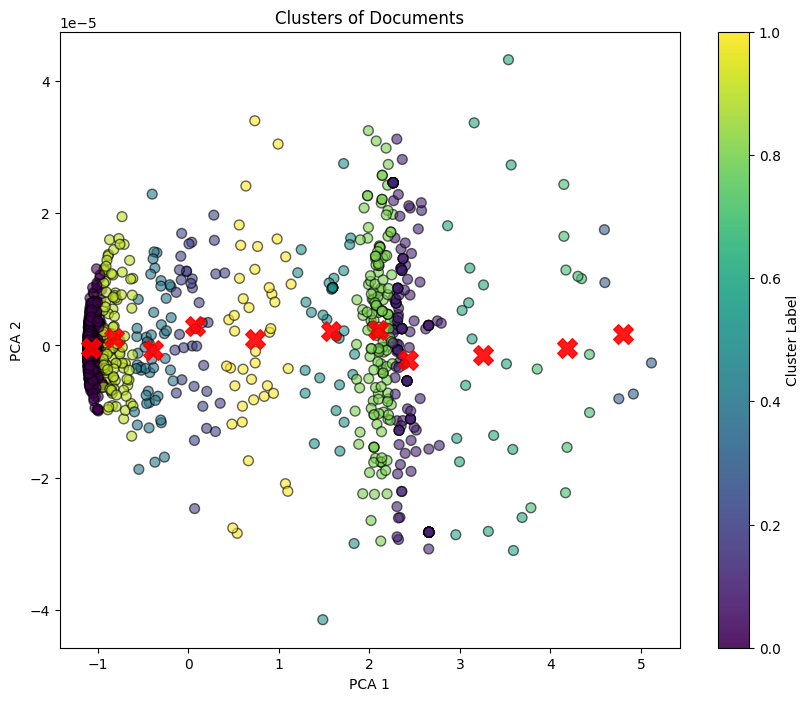

In [350]:
# Scatter plot of the first two PCA components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)

# Plot centroids
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.9, marker='X')

plt.title('Clusters of Documents')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster Label')

plt.show()